# Séance nº5 : régression (fin) ; intégration numérique

In [2]:
import numpy as np 
import matplotlib.pyplot as plt #import des packages

[Years, SMB, Albedo_mean]=np.loadtxt('Donnees_BM-Albedo_Argentiere_2000-2014.csv',skiprows=1,unpack=True)
#import des données "unpack" permet de séparer nos données en 3 variables dans notre cas 

mean_x=np.mean(Albedo_mean)
n=len(Albedo_mean)
Var_albedo=1/n*np.sum((Albedo_mean-mean_x)**2) #Variance albedo
std_x=np.sqrt(Var_albedo)#ecart type albedo

mean_y=np.mean(SMB)
Var_SMB=1/n*np.sum((SMB-mean_y)**2)#Variance Bilan de masse
std_y=np.sqrt(Var_SMB)#ecart type Bilan de masse

#coefficient de corrélation linéaire
r = 1./(std_x * std_y * n) * np.sum(  (Albedo_mean-mean_x) * (SMB-mean_y))
#coefficient de détermination (google it!!!)
r2 = r**2

# Puis, on peut estimer, a et b, respectivement la pente et l'intercept de la droite de régression 
#ayant pour équation bm = a*alb+b.

a = r * std_y / std_x #calcul de a. la pente de notre regression linéaire
b = np.mean(SMB) - a * np.mean(Albedo_mean) #calcul de b. l'intercept ou l'ordonnée à l'origine de notre régression 

sse = np.sum( (SMB - (a * Albedo_mean + b))**2 )#somme au carré des erreurs par rapport au données mesurées
std_e = np.sqrt(( 1./ (n - 2)) * sse ) 
std_a = std_e / (np.sqrt(n) * std_x) # Ecart-type sur la pente = 3.2
std_b = std_a * np.sqrt((1./n) * np.sum(Albedo_mean**2)) # Ecart-type sur l'intercept = 1.3


# Puis on trace cette droite

regression = a*Albedo_mean + b # Ici on recalcule les valeurs de bilan si elles étaient toutes sur la droite 
#(cela nous permet en fait de tracer cette droite de correlation.)


alea=np.random.randint(0,len(SMB)-1,size=(15,3000))# je crée une matrice de 15 par 3000 contenant des valeurs 
#aléatoires comprises entre 0 et 14. 

bilan=SMB[alea] #je crée un matrice de même taille que "alea" mais contenant les valeurs de SMB correspondant
# à la valeur de alea. 
albedo_m=Albedo_mean[alea] #idem pour albedo



## 1. Fin de l’exercice sur la corrélation entre albedo et bilan de masse d’un glacier

Le bilan de masse (gain ou perte nette de masse de l’ensemble du glacier) a aussi été mesuré. Le jeu de données (fichier ‘Donnees\_BM-Albedo\_Argentiere\_2000-2014.csv’) contient l’albedo moyen (minimum atteint en septembre) et le bilan de masse, pour 15 années.

\* Estimation des incertitudes du modèle linéaire par approche Monte-Carlo : ce modèle est appliqué sur 3000
échantillons des données (technique 'Bootstrap'). Ré-échantillonner les couples de valeurs albedo - bilan de
masse 3000 fois (avec remise). Pour chaque échantillon (parmi les 3000) de 15 couples de valeurs, calculer
pente et intercept de la régression linéaire. Calculer enfin moyenne et écart type de ces deux paramètres.
Comparer avec les statistiques obtenues ci-dessus sous hypothèse de distribution normale.

pente= 14.131662901856338 pente moyenne= 16.186048441353357 intercept= -7.153856789768209 intercept moyen= -8.083387859246539


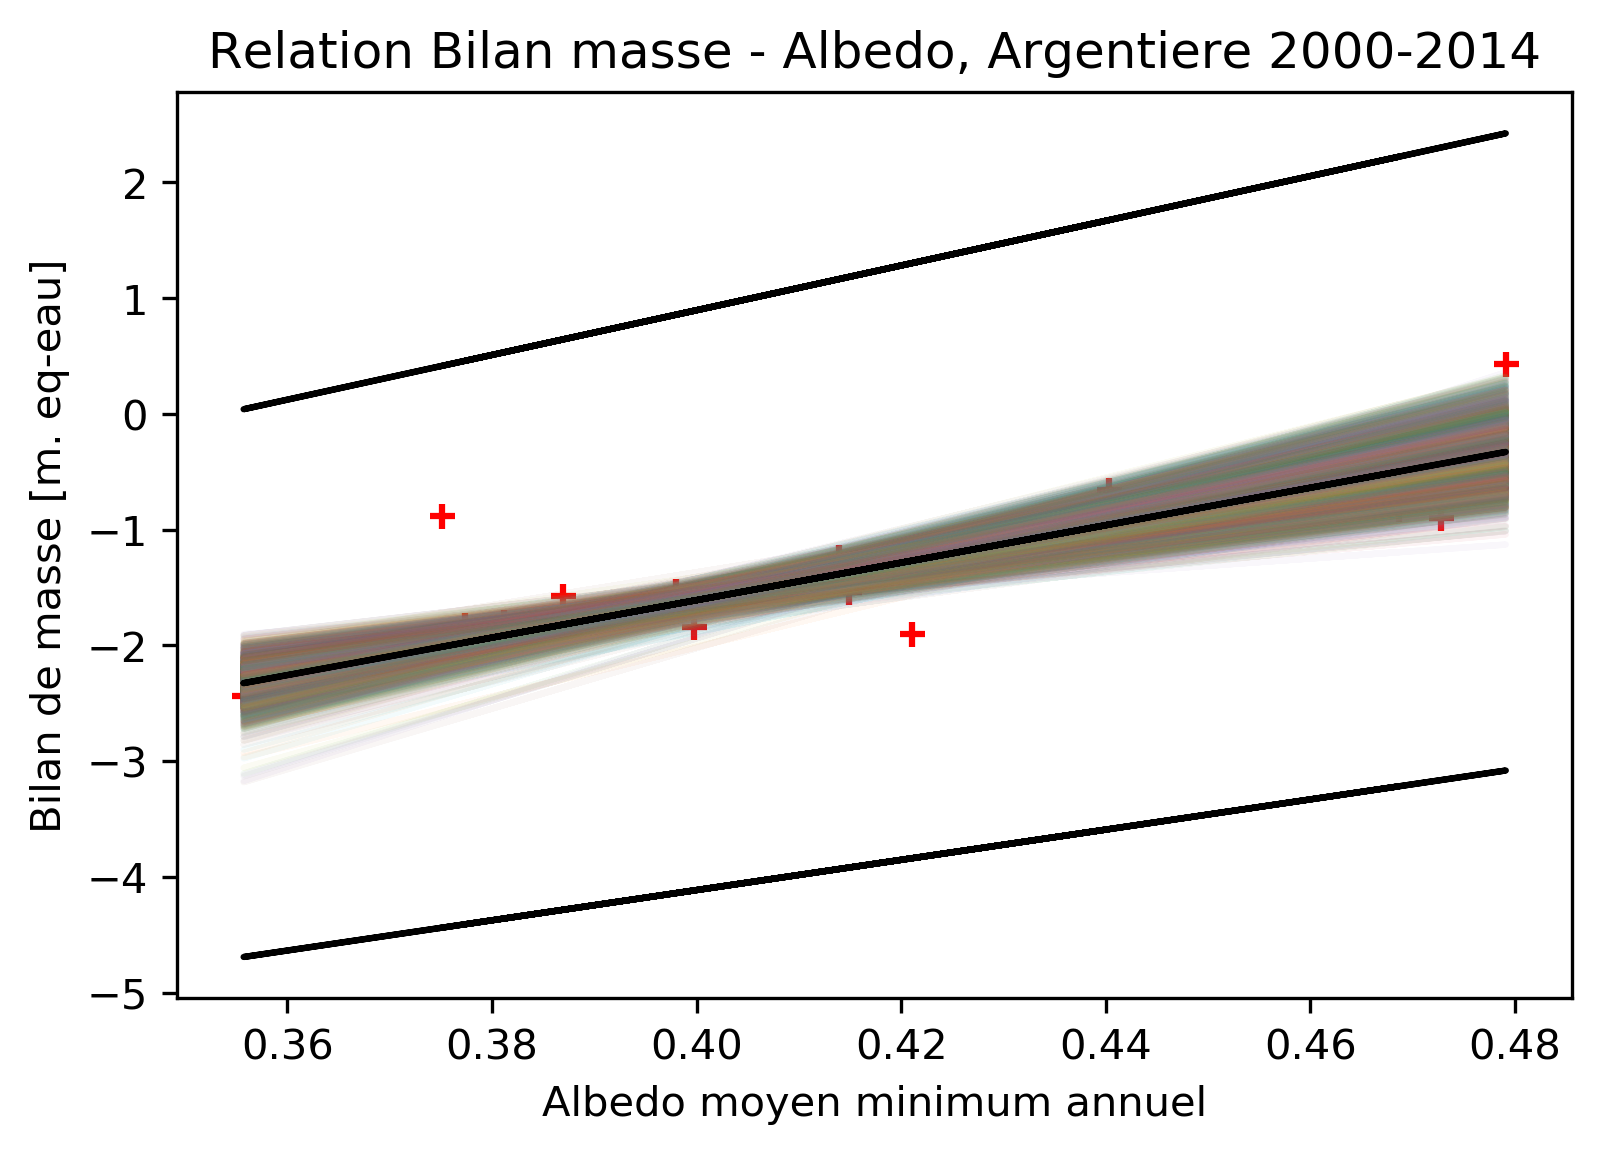

In [6]:
from scipy import stats

alea=np.random.randint(0,len(SMB)-1,size=(15,3000))# je crée une matrice de 15 par 3000 contenant des valeurs 
#aléatoires comprises entre 0 et 14. 

bilan=SMB[alea] #je crée un matrice de même taille que "alea" mais contenant les valeurs de SMB correspondant
# à la valeur de alea. 
albedo_m=Albedo_mean[alea] #idem pour albedo

slope=np.zeros(3000)
intercept=np.zeros(3000)
r_value=np.zeros(3000)
p_value=np.zeros(3000)
std_err=np.zeros(3000)
new_y=np.zeros((len(Albedo_mean),3000))

plt.figure(1,dpi=300)
for i in range(3000):
    slope[i], intercept[i], r_value[i], p_value[i], std_err[i] = stats.linregress(albedo_m[:,i], bilan[:,i])
    
    new_y[:,i]=slope[i]*Albedo_mean+intercept[i]
    
    
    plt.plot(Albedo_mean,new_y[:,i],alpha=0.05)
    

    
plt.scatter(Albedo_mean,SMB,color='red',marker='+')
plt.xlabel('Albedo moyen minimum annuel')
plt.ylabel('Bilan de masse [m. eq-eau]')
plt.title('Relation Bilan masse - Albedo, Argentiere 2000-2014')

mean_slope=np.mean(slope)
std_slope=np.std(slope)
mean_intercept=np.mean(intercept)
std_intercept=np.std(intercept)

plt. plot(Albedo_mean,mean_slope*Albedo_mean+mean_intercept,'k')
plt. plot(Albedo_mean,(mean_slope-std_slope)*Albedo_mean+(mean_intercept-std_intercept),'k')
plt. plot(Albedo_mean,(mean_slope+std_slope)*Albedo_mean+(mean_intercept+std_intercept),'k')

print('pente=',a,'pente moyenne=',mean_slope,'intercept=',b,'intercept moyen=',mean_intercept)

## 2. Introduction à l’intégration numérique

 Il est courant en géosciences de faire face à une intégrale qu’il est impossible de calculer analytiquement. C’est souvent pour une des deux raisons suivantes :

on connaît l’équation différentielle qui décrit le phénomène (lois physiques), mais pas sa primitive ;

on connaît le phénomène par des mesures de terrain, et on a besoin d’intégrer l’un des paramètres dans le temps ou l’espace (intégration d’un débit ou des précipitations, par exemple).

 Pour intégrer numériquement une équation différentielle, ou des données, on a besoin des valeurs pour des pas de temps ou d’espace ‘discrets’. Entre ces pas, les valeurs exactes de ces paramètres ne sont pas connues, et des hypothèses sur ces valeurs manquantes sont nécessaires. Cette discrétisation, inhérente à l’approche numérique, introduit une erreur sur le résultat de l’intégration. Pour réduire cette erreur, il faut d’une part réduire la taille des pas (mais au détriment du coût de calcul), d’autre part utiliser des hypothèses sur les valeurs manquantes plus ‘réalistes’ (ce qu’on appelle des schémas numériques).

### 2. 1 *Le schéma d’intégration : la méthode des trapèzes*

 Soit une fonction *f*(x), que l’on veut intégrer sur l’intervalle \[x<sub>0</sub>,x<sub>N</sub>\]. Cet intervalle est discrétisé en N intervalles égaux de longueur ∆x. La méthode d’intégration des trapèzes consiste à approcher l’intégrale de la fonction *f* sur chaque intervalle \[x<sub>i\\ </sub>, x<sub>i+1</sub>\] = ∆x par l’aire d’un trapèze :

$\int_{x_i}^{x_{i+1}}f(x) dx \approx \frac{\Delta x (f(x_i)+f(x_{i+1}))}{2} $(1)

Cette formule (1) est le résultat de l’intégration du développement limité d’ordre 1 de *f*(x), dont le résultat exact est :

$\int_{x_i}^{x_{i+1}}f(x) dx=\frac{\Delta x (f(x_i)+f(x_{i+1}))}{2} +O(\Delta x^3 f'')$ (2)

Le second terme du second membre de l’équation (2) quantifie l’erreur commise sur l’intégrale de *f* approchée par la méthode des trapèzes. En choisissant ce schéma, l’ordre de grandeur de l’erreur est quantifié par la valeur faisant intervenir la valeur du pas d’intégration ∆x ainsi que la dérivée seconde de la fonction *f*. (La valeur de l’erreur est fondamentale quand on cherche à faire des calculs précis et justes.)

L’interprétation “graphique” du schéma numérique est donnée sur la figure. On comprend alors que plus le pas d’intégration ∆x est petit et plus on se rapproche d’un calcul précis pour la valeur finale de l’intégrale.
![figure2](../TP4/figureTP4_2.png)
Figure : a) Fonction f(x) à intégrer sur l’intervalle d’intégration \[x<sub>0</sub>,x<sub>N</sub>\] , discrétisé en (N+1) points équidistants. Les figures b) et c) illustrent le schéma numérique. L’intégrale entre deux points x<sub>i</sub> et x<sub>i+1</sub> de f(x) est approchée en calcul numérique soit par b) l’aire du trapèze x<sub>i</sub> x<sub>i+1</sub> f<sub>i+1</sub> f<sub>i</sub> , soit par c) l’aire du rectangle de base x<sub>i</sub> et x<sub>i+1</sub> et de hauteur (f<sub>i</sub> + f<sub>i+1</sub> )/2.

Soit une fonction *f* que l’on veut intégrer sur un intervalle \[x<sub>0</sub>,x<sub>N</sub>\] par la méthode des trapèzes.

#### a) Ecrire la relation entre ∆x et N (le nombre d’intervalles).

$N.\Delta x = x_N - x_0$

#### b) Montrer que l’aire du trapèze et l’aire du rectangle des figures b et c sont les mêmes.

$aire\space du\space trapèze = \Delta x.f_{i+1} + \Delta x.(f_i - f_{i+1})/2 = \Delta x.(f_i + f_{i+1})/2$

$aire\space du\space rectangle = \Delta x.(f_i + f_{i+1})/2$

#### c) Ecrire la relation (1) sur tout l’intervalle \[x<sub>0</sub>,x<sub>N</sub>\], en fonction des f(x<sub>i</sub>), i∈\[0,N\].

On cherche à estimer $\int_{x_0}^{x_N} f(x) dx = \sum_{i=0}^{N-1}\int_i^{i+1} f(x) dx $,

selon l’approximation $$\sum_{i=0}^{N-1}\int_i^{i+1} f(x) dx \approx \sum_{i=0}^{N-1} \Delta x \frac{f(x_i)+f(x_{i+1})}{2}$$.

On calcule : $$\int_{x_0}^{x_N} f(x) dx \approx  \Delta x . \sum_{i=0}^{N} f(x_i)-\Delta x \frac{f(0)+f(x_{N})}{2}$$.

Il faut bien noter que le terme correctif devient faible par rapport au terme principal lorsque N augmente et que Dx diminue.

### 2.2 Intégration de la fonction *f*(x) = x<sup>2</sup>.sinx sur l’intervalle \[0,π\]

#### a) Intégration analytique (par parties).

$\int_0^\pi x^2.sin(x) dx$ à calculer

Première étape : $[x2.cosx] ' = 2x.cosx - x^2.sinx$

Seconde étape :  $[x.sinx] ' = sinx + x.cosx$

D’où :
$$\int_0^\pi x^2.sin(x)dx=[x^2.cos(x)]+2\int_0^\pi x.cos(x) dx$$
$$\int_0^\pi x^2.sin(x)dx=[x^2.cos(x)]+2.\left([x.sin(x)]-\int_0^\pi sin(x) dx\right)$$
$$\int_0^\pi x^2.sin(x)dx=[x^2.cos(x)]+2.[x.sin(x)]+2.[cos(x)]$$
$$\int_0^\pi x^2.sin(x)dx=\pi^2-4$$
soit environs 5.8696044

#### b) Ecrire l’algorithme permettant d’appliquer le schéma numérique (1) pour l’intégration de *f*.

Au début de l’algorithme, l’utilisateur donne le nombre de pas (N). On utilisera une itération explicite (boucle). La fonction *f* est calculée dans une structure fonction.

  fixer le nombre d’intervalles N  
  fixer borne inférieure x0  
  fixer borne supérieure xn  
  calculer intervalle Dx = (xn - x0)/N  
  initialiser somme à 0  
  boucle de i = 0 à N
  
     xi = x0 + i*Dx
     
     somme = somme + Dx * fonc(xi)
     
  fin boucle
  
  somme = somme - Dx*[fonc(x0) + fonc(xn)]/2

  definir fonction fonc(x)
  
     retourner fonc(x) = x*x * sin(x)
     
  fin fonction

#### c) Transcrire l’algorithme en programme. Calculer l’intégrale de *f* pour des valeurs différentes de N (10, 100, 1000). Calculer l’erreur. Calculer l’intégrale avec une fonction résidente de type *integrate* (voir la syntaxe).

In [4]:
import numpy as np

def fonc(x):
    y=x**2*np.sin(x)
    return y

N=int(input('N='))

x=0
somme=0
Dx=(np.pi)/N # intervale x_max et x_min


for i in range(N):
    somme += Dx*fonc(x)
    
    x+= Dx
    


integrale= somme - Dx *(fonc(0)-fonc(np.pi))/2

print(integrale)


err= (np.pi**2-4)-integrale

print('erreur=',err)

N=10
5.788459944515225
erreur= 0.08114445657413327
